In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import networkx as nx
from matplotlib import cm
jax.config.update("jax_enable_x64", True)
plt.rcParams['text.usetex'] = True
runs = {}
for init in ["heb", "rand"]:
    runs[init] = {}
    for lock in ["fix", "opt"]:
        runs[init][lock] = pd.read_csv(f"run_data/{init}_{lock}_locking.csv")

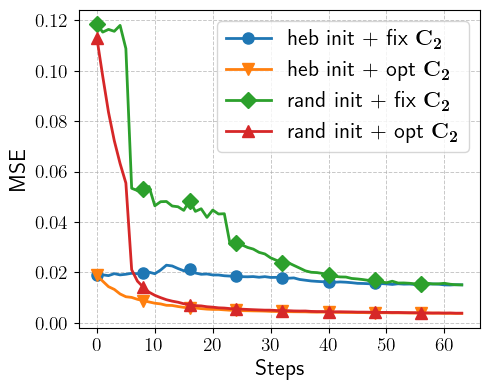

In [2]:
# Visualze Training Loss
# Remove the columns ends with _MAX or _MIN and remove Step column
def remove_redudant_columns(run_csv):
    run_csv = run_csv.loc[:,~run_csv.columns.str.endswith('_MAX')]
    run_csv = run_csv.loc[:,~run_csv.columns.str.endswith('_MIN')]
    run_csv = run_csv.loc[:,~run_csv.columns.str.endswith('Step')]
    return run_csv

# X-axis: Steps
# Y-axis: Max-Squared Error
# Line: Mean and shaded area for the min/max
# Two lines: One for each run

plt.figure(figsize=(5, 4))  # Set a larger figure size
markers = ['o', 'v', 'D', '^']
marker_id = 0

for init in ["heb", "rand"]:
    for lock in ["fix", "opt"]:
        run = remove_redudant_columns(runs[init][lock])

        mean = run.mean(axis=1)
        steps = np.arange(0, len(mean))
        label = f"{init} init + {lock} " + r"$\mathbf{C_2}$"
        marker = markers[marker_id]
        marker_id += 1

        # Plotting, show marker every 5 steps
        plt.plot(steps, mean, label=label, marker=marker, markevery=8, linewidth=2, markersize=8)  


# Enhancing aesthetics
plt.xlabel('Steps', fontsize=16)  # Larger label font size
plt.ylabel('MSE', fontsize=16)  # Larger label font size

# Adjust tick size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a grid with a finer style
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

# Modify legend
plt.legend(loc='upper right', fontsize=16, frameon=True)

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.savefig('obc_loss_vs_iter.pdf', dpi=300, bbox_inches='tight')
plt.show()

8


/var/folders/zv/1cq_05k97dl9b9_kf_drhmdr0000gp/T/ipykernel_60011/3439896520.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('BrBG')
/var/folders/zv/1cq_05k97dl9b9_kf_drhmdr0000gp/T/ipykernel_60011/3439896520.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


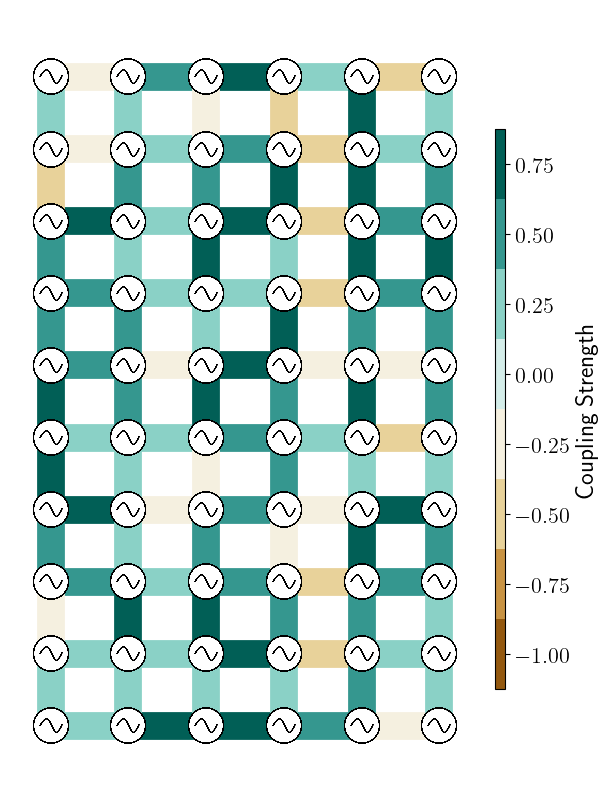

In [3]:
# Visualize the coupling strength
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mppng

oscillator_image_path = 'oscillator.png'
oscillator_img = mppng.imread(oscillator_image_path)

init_weight_file = "weights/init_weight.npz"
weights = jnp.load(init_weight_file)
n_choices = weights['digital'].shape[-1]
n_bits = jnp.log2(n_choices)
val_choices = [(-(2 ** (n_bits - 1)) + i) * 2 / n_choices for i in range(n_choices)]
print(n_choices)

# Use a single color map for both row and column weights
# Scale so that the extreme values are not at the ends of the color map
cmap = cm.get_cmap('BrBG')
weight_min, weight_max = min(val_choices) * 1.25, max(val_choices) * 1.25

# Normalize weights for consistent coloring across all coupling strengths
norm = plt.Normalize(vmin=weight_min, vmax=weight_max)

# Function to add custom node symbols (oscillator image)
def add_image_at_node(ax, pos, img, zoom=0.1):
    """ Add an image at the node position """
    for p in pos.values():
        imagebox = OffsetImage(img, zoom=zoom)
        ab = AnnotationBbox(imagebox, p, frameon=False)
        ax.add_artist(ab)

def plot_grid_with_weights(row_weights, column_weights, ax, cmap=cmap, norm=norm):
    # Create a 10x6 grid graph
    rows, cols = 10, 6
    G = nx.grid_2d_graph(rows, cols)

    # Position the nodes in a grid layout
    pos = {(i, j): (j, -i) for i in range(rows) for j in range(cols)}

    # Draw the nodes as small dots
    nx.draw(G, pos, node_size=0, node_color='black', with_labels=False, ax=ax)

    # Draw horizontal edges with row weights (colored by normalized weight)
    for i in range(rows):
        for j in range(cols - 1):
            edge = ((i, j), (i, j + 1))
            weight = row_weights[i, j]
            G.edges[edge]['color'] = cmap(norm(weight))
            G.edges[edge]['weight'] = weight
            nx.draw_networkx_edges(G, pos, edgelist=[edge], width=20, edge_color=[G.edges[edge]['color']], ax=ax)

    # Draw vertical edges with column weights (colored by normalized weight)
    for i in range(rows - 1):
        for j in range(cols):
            edge = ((i, j), (i + 1, j))
            weight = column_weights[i, j]
            G.edges[edge]['color'] = cmap(norm(weight))
            G.edges[edge]['weight'] = weight
            nx.draw_networkx_edges(G, pos, edgelist=[edge], width=20, edge_color=[G.edges[edge]['color']], ax=ax)

    # Add oscillator symbol at each node position
    add_image_at_node(ax, pos, oscillator_img, zoom=0.05)


def convert_weights(w: jnp.ndarray):
    # Weight consists of:
    # 1. flattened 10x5 vector for the coupling in every row, plus
    # 2. flattened 9x6 vector for the coupling in every column
    # The element in the vector is an one-hot encoding of the coupling strength
    # The one-hot index corresponds to the coupling strength chosen from the list


    row_ks = w[:50].reshape(10, 5, -1).argmax(axis=2)
    col_ks = w[50:].reshape(9, 6, -1).argmax(axis=2)

    row_ks = np.array([val_choices[i] for i in row_ks.flatten()]).reshape(10, 5)
    col_ks = np.array([val_choices[i] for i in col_ks.flatten()]).reshape(9, 6)

    return row_ks, col_ks

# Create a figure with 3 subplots
# Init_weight, Fixed locking, Optimized locking

fig, ax = plt.subplots(1, 1, figsize=(5, 8))

init_row_ks, init_col_ks = convert_weights(weights["digital"])
locking = weights["analog"][0]
plot_grid_with_weights(init_row_ks, init_col_ks, ax)
# ax.set_title("Initial Coupling\n(" + r"$\mathbf{C_2}=$" + f"{locking})", fontsize=22, fontweight='bold')

# Fixed locking
# for seed in range(1):
#     weight_file = f"weights/{seed}.npz"
#     weights = jnp.load(weight_file)
#     row_ks, col_ks = convert_weights(weights["digital"])
#     plot_grid_with_weights(row_ks, col_ks, ax[1])
# ax[1].set_title("Optimized Coupling\nw/ Fixed Locking", fontsize=22, fontweight='bold')

# # Optimized locking
# for seed in range(1):
#     weight_file = f"weights/train_locking_{seed}.npz"
#     weights = jnp.load(weight_file)
#     row_ks, col_ks = convert_weights(weights["digital"])
#     plot_grid_with_weights(row_ks, col_ks, ax[2])
#     print(weights["analog"])
# ax[2].set_title("Optimized Coupling\nw/ Optimized Locking", fontsize=22, fontweight='bold')



# Create a single shared colorbar for both row and column weights
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

plt.axis('off')
# Add the colorbar to the figure
levels = [-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75]
boundary = [lev - 0.125 for lev in levels] + [0.875]
cbar_ax = fig.add_axes([1.0, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax, ticks=levels, boundaries=boundary)
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Coupling Strength', fontsize=18)

# Final adjustments and display
plt.tight_layout()
plt.subplots_adjust(wspace=0.0, hspace=0.0, top=1)  # Adjust spacing between subplots
plt.savefig('obc_weight.pdf', dpi=300, bbox_inches='tight')
plt.show()




/var/folders/zv/1cq_05k97dl9b9_kf_drhmdr0000gp/T/ipykernel_60011/2078227800.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('coolwarm_r')


C_2= []
C_2= [3.18551122]
-0.5 0.5


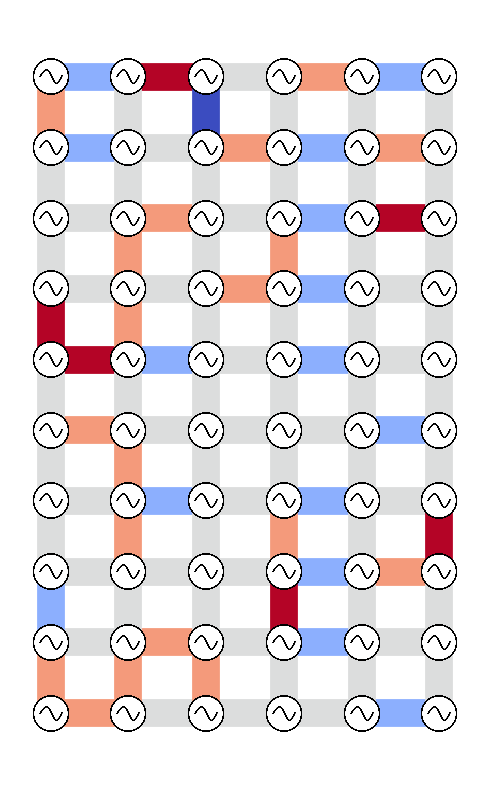

/var/folders/zv/1cq_05k97dl9b9_kf_drhmdr0000gp/T/ipykernel_60011/2078227800.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


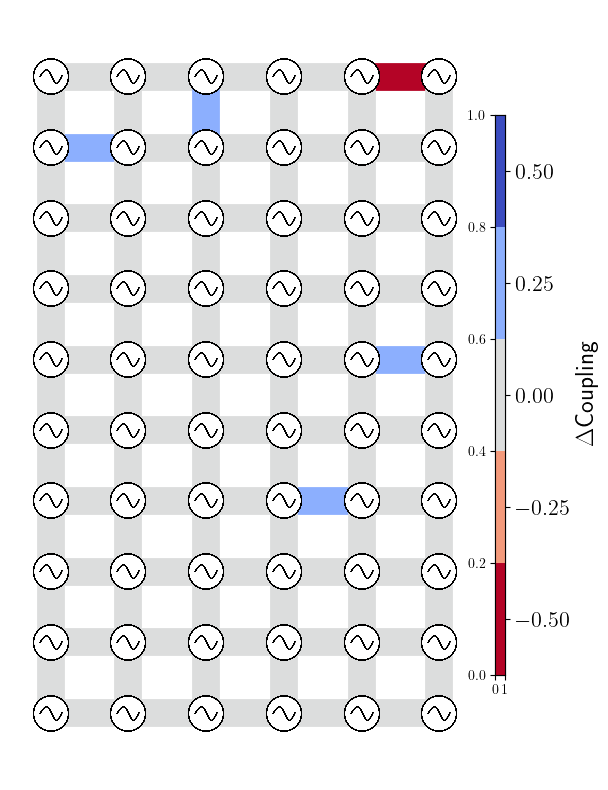

In [4]:
# Plot the diff of the grid

seed = 2

# cmap = cm.get_cmap('Reds')
cmap = cm.get_cmap('coolwarm_r')
# save_names = ["heb-init-fix-locking", "heb-init-opt-locking", "rand-init-opt-locking"]
save_names = ["heb-init-fix-locking", "heb-init-opt-locking"]
# weight_files = [f"weights/1003_mse/{seed}.npz", f"weights/1003_mse/train_locking_{seed}.npz", f"weights/1003_rand_init/{seed}.npz"]
weight_files = [f"weights/1003_mse/{seed}.npz", f"weights/1003_mse/train_locking_{seed}.npz"]

row_diffs, col_diffs = [], []

for file_name in weight_files:
    weights = jnp.load(file_name)
    row_ks, col_ks = convert_weights(weights["digital"])
    print("C_2=", weights["analog"])
    row_diffs.append(row_ks - init_row_ks)
    col_diffs.append(col_ks - init_col_ks)
    
row_diffs = jnp.stack(row_diffs)
col_diffs = jnp.stack(col_diffs)
weight_max = max(row_diffs.max(), col_diffs.max())
weight_min = min(row_diffs.min(), col_diffs.min())

# Make the upper and lower bound center around 0
weight_max = max(abs(weight_max), abs(weight_min))
weight_min = -weight_max
print(weight_min, weight_max)
norm = plt.Normalize(vmin=weight_min, vmax=weight_max)

for save_name, row_diff, col_diff in zip(save_names, row_diffs, col_diffs):

    fig, ax = plt.subplots(1, 1, figsize=(5, 8))
    plot_grid_with_weights(row_diff, col_diff, ax, cmap, norm)
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    plt.axis('off')
    # Add the colorbar to the figure
    # Only show in the last figure
    if save_name == save_names[-1]:
        cbar_ax = fig.add_axes([1.0, 0.15, 0.02, 0.7])
        levels = [-0.5, -0.25, 0, 0.25, 0.5]
        boundary = [lev - 0.125 for lev in levels] + [levels[-1] + 0.125]
        cbar_ax = fig.add_axes([1.0, 0.15, 0.02, 0.7])
        cbar = fig.colorbar(sm, cax=cbar_ax, ticks=levels, boundaries=boundary)
        cbar.ax.tick_params(labelsize=16)
        cbar.set_label(r"$\Delta$" + 'Coupling', fontsize=18)

    # Final adjustments and display
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.0, hspace=0.0)  # Adjust spacing between subplots
    plt.savefig(f'{save_name}.pdf', dpi=300, bbox_inches='tight')

    plt.show()

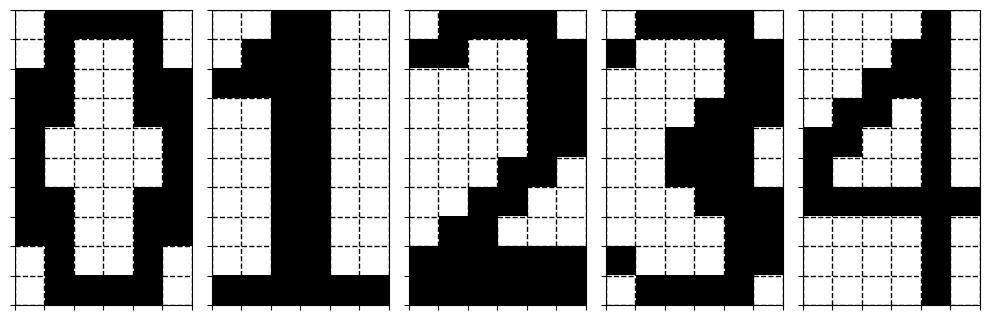

In [5]:
from pattern_recog_dataloader import NUMBERS_10x6

def plot_grid_with_patterns(ax: plt.Axes, pattern):
    ax.imshow(pattern, cmap="gray_r", vmin=0, vmax=1)
    
    # Show grid lines
    ax.set_xticks(np.arange(-.5, 6, 1))
    ax.set_yticks(np.arange(-.5, 10, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(which='both', color='black', linestyle='--', linewidth=1)


fig, ax = plt.subplots(1, 5, figsize=(10, 6))
for i, pattern in enumerate(NUMBERS_10x6.values()):
    plot_grid_with_patterns(ax[i], pattern)
plt.tight_layout()
plt.savefig('obc_patterns.pdf', dpi=300, bbox_inches='tight')
plt.show()